# Simulating a news personalization scenario using Contextual Bandits- Adding multiple changes over time and varying noise to the reward distribution

In this notebook we will simulate the effect of adding multiple changes to the reward distribution over time and of introducing varying noise in the reward distribution. This work is based off of Scenario 2 of the Contextual Bandits tutorial found here: https://vowpalwabbit.org/tutorials/cb_simulation.html. 

Let's first start with importing the necessary packages and defining important functions and constants. All of the below are explained in further detail in the tutorial linked earlier.

In [16]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [17]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [18]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [19]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [20]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [21]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

#get_preference_matrix(get_cost)

In [22]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [23]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

## Adding Multiple Changes to the Reward Distribution Over Time
To simulate multiple changes to the reward distribution over time, I added an additional cost function to switch to.

In [24]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [25]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost_new1)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [27]:
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'finance':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'health':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost_new2)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0    -1.0    0.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0
Tom   afternoon         0.0      0.0  -1.0     0.0    0.0       0.0     0.0
      morning           0.0     -1.0   0.0     0.0    0.0       0.0     0.0

In [28]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

Now let's see the effect of the multiple changes to the reward distribution, starting with the default epsilon-greedy exploration algorithm.

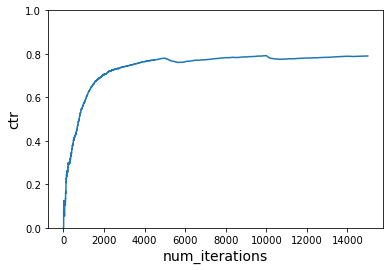

In [30]:
# use first, second, then third reward functions

# Instantiate learner in VW using epsilon-greedy exploration algorithm
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

Repeating with explore-first algorithm

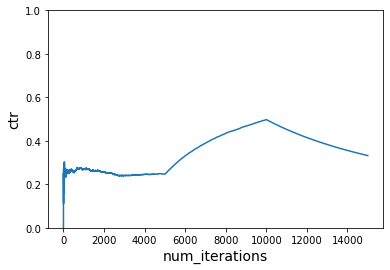

In [31]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

Now trying the Bagging Explorer algorithm

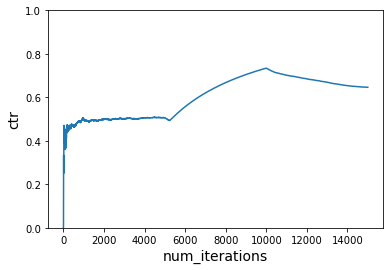

In [32]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

Using softmax eplorer:

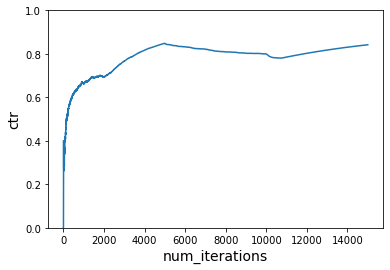

In [33]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

Finally, let's compare the performance of these exploration algorthms to not learning at all. 

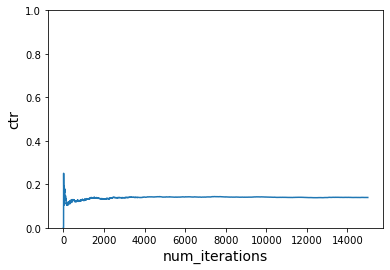

In [36]:
# Do not learn

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

From these plots, a few things jump out. All of the exploration algorithms showed significant improvement over not learning at all. It appears that softmax explorer did the best, however, there is a period of several thousand iterations where its performance worsened. In comparison, the epsilon-greedy algorithm almost matched its performance and was performed more consistently over iterations potentially making it a better algorithm for practical use on this problem. The bagging explorer and explore first algorithms did significantly worse but had similar learning curve shapes to eachother. The bagging explorer algorithm consistently outperformed explore first, but both are poor fits for this problem.

## Adding Varying Noise to the Reward Distribution 
To simulate varying noise, I'm going to add small random noise (between 0 and 0.5) to the cost function. This guaranteees that "liked articles" will always have a negative cost (value unknown) and disliked articles will have a 0 or positive cost. The preference matrix below is an example of one set of preferences. When the simulation is run, the preference matrix will change.

In [41]:
def get_noisy_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return random.uniform(0, 0.5) + USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return random.uniform(0, 0.5) + USER_LIKED_ARTICLE
        else:
            return random.uniform(0, 0.5)
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return random.uniform(0, 0.5) + USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return random.uniform(0, 0.5) + USER_LIKED_ARTICLE
        else:
            return random.uniform(0, 0.5)
        
get_preference_matrix(get_noisy_cost)

actions              camping   finance      food    health     music  \
users times_of_day                                                     
Anna  afternoon     0.362073  0.147795  0.480036  0.018762  0.368787   
      morning       0.108406  0.402965  0.422287  0.359622  0.305238   
Tom   afternoon     0.203399  0.463223  0.388269  0.482887 -0.721941   
      morning       0.345441  0.402098  0.446028  0.015303  0.433613   

actions             politics    sports  
users times_of_day                      
Anna  afternoon    -0.860553  0.129820  
      morning       0.490970 -0.937963  
Tom   afternoon     0.046183  0.184426  
      morning      -0.904301  0.270103

Now we want to see the effect of this on different exploration algorithms. Starting with the default epsilon-greedy:

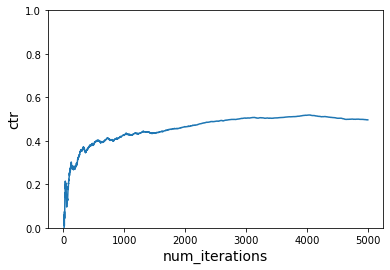

In [43]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_noisy_cost)

plot_ctr(num_iterations, ctr)

I was curious about how much the noise affected the learning curve and not jsut the performance of the algorithm. Here are two additional runs of the algorithm:

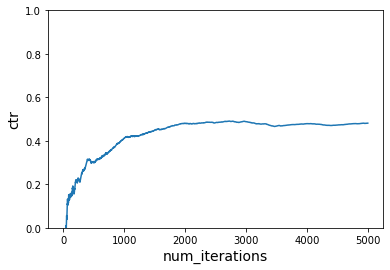

In [44]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_noisy_cost)

plot_ctr(num_iterations, ctr)

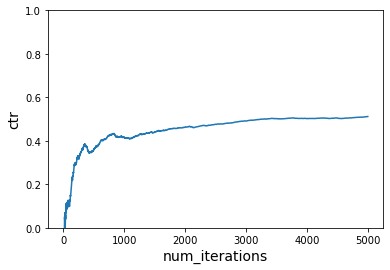

In [45]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_noisy_cost)

plot_ctr(num_iterations, ctr)

These plots are not identical but definitely very similar. They fluctuate in the first thousand or so iterations before leveling off around 0.5.

Now trying with explore-first

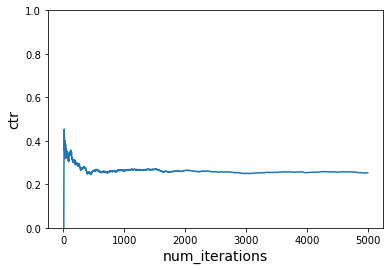

In [52]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_noisy_cost)

plot_ctr(num_iterations, ctr)

The bagging explorer algorithm:

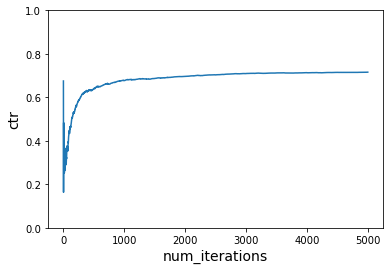

In [53]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_noisy_cost)

plot_ctr(num_iterations, ctr)

Softmax explorer:

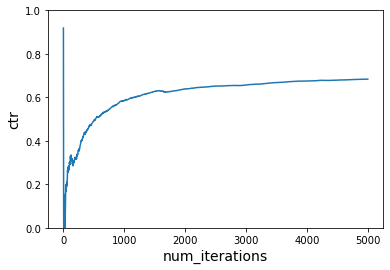

In [54]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_noisy_cost)

plot_ctr(num_iterations, ctr)

And finally, not learning at all

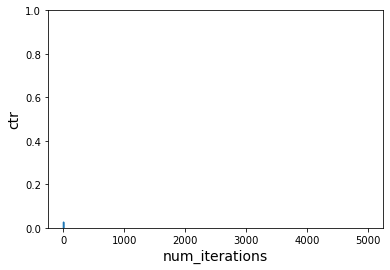

In [65]:
# Do not learn

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_noisy_cost]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

I'm very confused by the above plot, but needless to say, not learning in this noisy situation is definitely a poor stratrgy. The bagging explorer algorithm did the best, followed by softmax explorer. Both had massive drops in performance in the initial iterations of training but improved and leveled out. This is interesting considering that the bagging explorer algorithm did very poorly in the previous simulation, but here it shos its ability to handle noise well. Epsilon-greedy didn't do too well, but it had a consistent fairly smooth learning curve. The worst performer was explore-first which peaked early and flatlined around 2.5. From this (extremely limited) data, I'd conclude that bagging explorer is the best algorithm for noisy situations while softmax explorer is the best algorithm in general for time varying situations.